# Fine-Tuning and Quantization of MobileNetV3 for AI Deck

This notebook demonstrates the process of fine-tuning a pre-trained MobileNetV3Small model on a custom dataset and quantizing it for deployment on the AI Deck. The AI Deck is a powerful tool for running lightweight AI models on drones, and optimizing models for it involves careful consideration of size, accuracy, and compatibility.

The notebook is divided into the following sections:

1. **Data Preparation**: Loading and augmenting the dataset.
2. **Model Definition**: Setting up a MobileNetV3-based architecture.
3. **Training**: Fine-tuning the model for our custom dataset.
4. **Evaluation**: Assessing the model's performance.
5. **Model Conversion and Quantization**: Preparing the model for deployment on the AI Deck.
6. **Testing the Quantized Model**: Verifying the functionality of the quantized model.

Let's get started!


## Prerequisites

Before running this notebook, ensure you have the following installed and configured:

1. **Python Environment**:
   - Python 3.8–3.11
   - A virtual environment or Conda environment is recommended to manage dependencies.

2. **Required Libraries**:
   - `TensorFlow >= 2.10`
   - `NumPy`
   - `Pandas`
   - `Matplotlib`
   - `Pillow`
   - `SciPy`
   - `Seaborn`

   You can install the required libraries with:
   ```bash
   pip install tensorflow numpy pandas matplotlib pillow scipy

3. **Dataset**:

   - A labeled dataset organized in the following structure:

    training_data/
      train/
        class1/
        class2/
        ...
      validation/
        class1/
        class2/
        ...

   - Ensure the dataset is prepared with appropriate augmentations for training.
   - For a quick start, you can use the provided example dataset: `training_data/training_data_christmas_packet.zip` Extract the archive to a folder before running the notebook.

4. **Hardware**:

   - A GPU-enabled machine is recommended for faster training.
    Ensure TensorFlow is configured to use your GPU if available.

5. **AI Deck Environment (for deployment)**:

   - Install the necessary tools and libraries to work with the AI Deck.

Refer to the official [AI Deck documentation](https://www.bitcraze.io/documentation/tutorials/getting-started-with-aideck/) documentation for setup instructions or README.

## Imports

In [13]:
import os
import argparse
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Resizing,
    Conv2D,
    GlobalAveragePooling2D,
    Dropout,
    Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Small

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

### Prepare the Dataset and Initialize Arguments
This section uses command-line style argument parsing adapted for the notebook environment. It initializes parameters and ensures the dataset is prepared.

In [7]:
# Emulate argparse in Jupyter
class Args:
    epochs = 20
    finetune_epochs = 20
    dataset_path = "training_data"
    batch_size = 8
    image_width = 324
    image_height = 244
    image_channels = 1
    print_plot = True

args = Args()

# Define paths
ROOT_PATH = f"{os.path.abspath(os.curdir)}"
DATASET_PATH = f"{ROOT_PATH}/{args.dataset_path}"

# Check and extract dataset if 'train' and 'validation' are missing
train_path = os.path.join(DATASET_PATH, "train")
val_path = os.path.join(DATASET_PATH, "validation")

if not os.path.exists(train_path) or not os.path.exists(val_path):
    zip_path = os.path.join(DATASET_PATH, "training_data_christmas_packet.zip")
    if not os.path.exists(zip_path):
        raise FileNotFoundError(
            f"The dataset zip file '{zip_path}' does not exist. "
            "Ensure the file is present in the dataset path."
        )

    print(f"Extracting dataset from {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATASET_PATH)
    print("Dataset extracted successfully.")

    # Re-check for the train and validation directories
    if not os.path.exists(train_path) or not os.path.exists(val_path):
        raise FileNotFoundError(
            f"After extraction, 'train' or 'validation' directories were still not found in '{DATASET_PATH}'."
        )

print(f"Dataset prepared at: {DATASET_PATH}")

# Data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    rescale=1.0 / 255.0
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)

if args.image_channels == 1:
    color_mode = "grayscale"
else:
    color_mode = "rgb"

# Load training and validation datasets
train_generator = train_datagen.flow_from_directory(
    f"{DATASET_PATH}/train",
    target_size=(args.image_width, args.image_height),
    batch_size=args.batch_size,
    class_mode="categorical",
    color_mode=color_mode
)

val_generator = val_datagen.flow_from_directory(
    f"{DATASET_PATH}/validation",
    target_size=(args.image_width, args.image_height),
    batch_size=args.batch_size,
    class_mode="categorical",
    color_mode=color_mode
)

# Save class labels to a text file
print("Class Indices:", train_generator.class_indices)
labels = "\n".join(sorted(train_generator.class_indices.keys()))
with open(f"{ROOT_PATH}/class_labels.txt", "w") as f:
    f.write(labels)


Dataset prepared at: /home/zboucek/mygit/cf/aideck-gap8-examples/examples/ai/classification/training_data
Found 1375 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Class Indices: {'background': 0, 'packet': 1}


### Model Building and Training

In this section, we will define the architecture of the neural network using MobileNetV3Small as the base model. The model will then be trained using the prepared dataset. The training will be conducted in two stages: initial training with frozen weights of the base model, and fine-tuning with unfrozen weights.


In [8]:
# Define the model architecture
base_model = MobileNetV3Small(
    input_shape=(244, 244, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze the base model for initial training

if args.image_channels == 1:
    print("Detected grayscale images, adding conversion layer.")
    input_layer = tf.keras.Sequential([
        tf.keras.Input(shape=(args.image_width, args.image_height, 1)),
        tf.keras.layers.Conv2D(filters=3, kernel_size=(1, 1), activation=None),
        tf.keras.layers.Resizing(244, 244, interpolation="bilinear")
    ])
else:
    print("Detected RGB images, resizing only.")
    input_layer = tf.keras.Sequential([
        tf.keras.Input(shape=(args.image_width, args.image_height, 3)),
        tf.keras.layers.Resizing(244, 244, interpolation="bilinear")
    ])

# Add custom layers on top of the base model
model = Sequential([
    input_layer,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(units=len(train_generator.class_indices), activation="softmax")
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
initial_epochs = args.epochs
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=initial_epochs
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune the model
fine_tune_epochs = args.finetune_epochs
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)

/home/zboucek/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Detected grayscale images, adding conversion layer.
Epoch 1/20


/home/zboucek/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 30s 153ms/step - accuracy: 0.5336 - loss: 0.7214 - val_accuracy: 0.4467 - val_loss: 0.7086
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.5331 - loss: 0.7043 - val_accuracy: 0.5533 - val_loss: 0.6887
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5289 - loss: 0.6976 - val_accuracy: 0.5533 - val_loss: 0.6879
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.5087 - loss: 0.7021 - val_accuracy: 0.5533 - val_loss: 0.6877
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.5582 - loss: 0.6885 - val_accuracy: 0.5489 - val_loss: 0.6891
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5280 - loss: 0.6894 - val_accuracy: 0.5533 - val_loss: 0.7254
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5489 - loss: 0.6940 - val_accuracy: 0.4644 - val_loss: 0.6902
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.5400 - loss: 0.6992 - val

### Saving the Trained Model and Evaluating Its Performance

Once the model has been trained, we save it for later use and evaluate its performance. The evaluation metrics include accuracy on both the training and validation datasets. This step ensures that the model is saved in a reusable format for conversion or deployment.

In [10]:
# Define paths to save the model
model_save_dir = os.path.join(os.getcwd(), "model")
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, "model.keras")

# Save the model in .keras format
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

Model saved to: /home/zboucek/mygit/cf/aideck-gap8-examples/examples/ai/classification/model/model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9990 - loss: 0.0042
Validation Loss: 0.0069
Validation Accuracy: 99.7778%


### Training Progress Visualization

In this section, we visualize the training progress using loss and accuracy metrics for both training and validation data. These plots help us understand whether the model is improving over time and if there are signs of overfitting or underfitting.

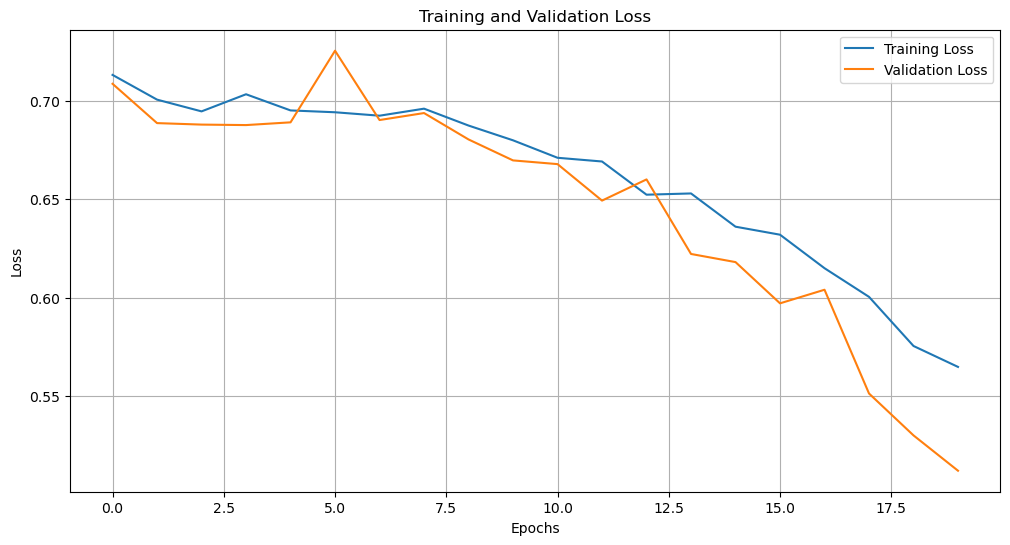

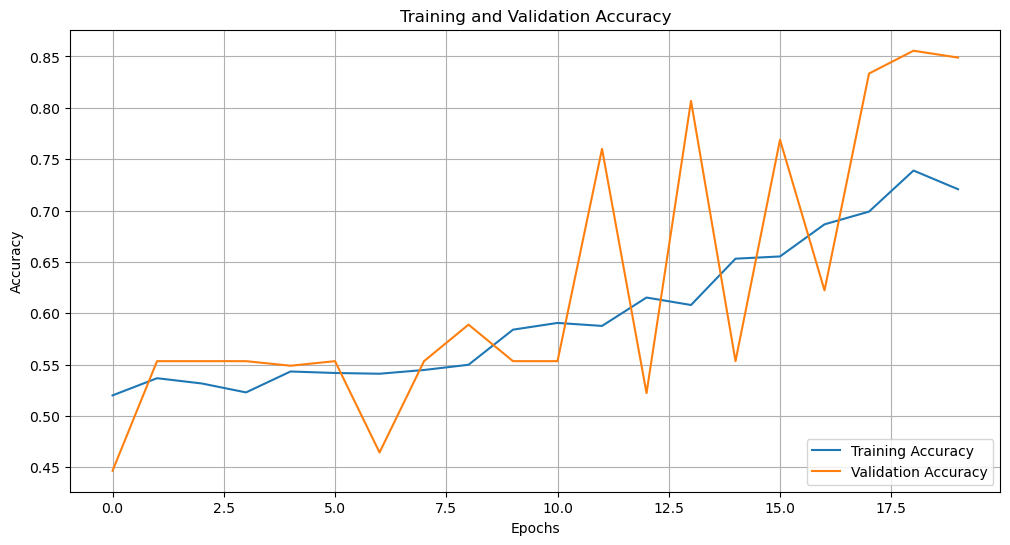

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step
Classification Report:

              precision    recall  f1-score   support

  background       0.41      0.41      0.41       201
      packet       0.52      0.52      0.52       249

    accuracy                           0.47       450
   macro avg       0.47      0.47      0.47       450
weighted avg       0.47      0.47      0.47       450



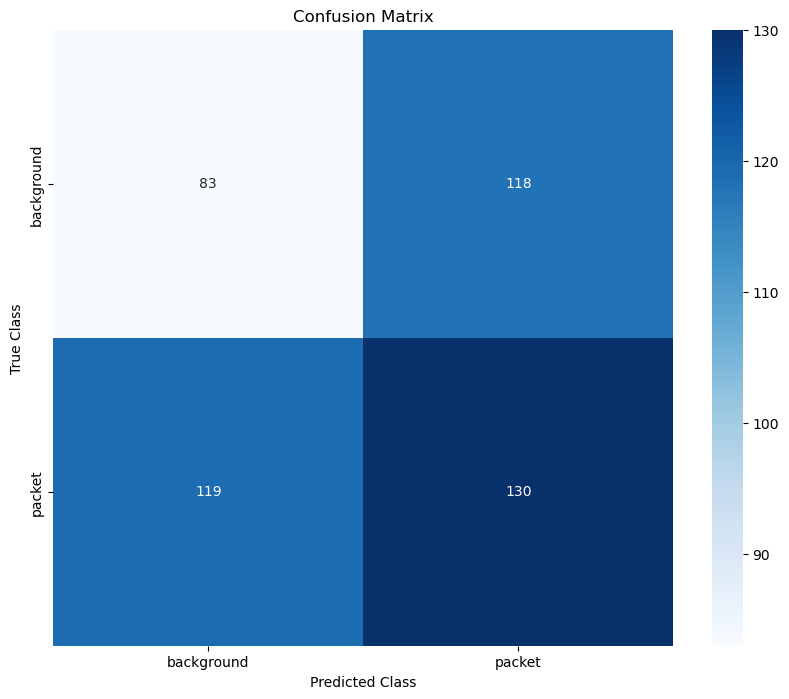

In [15]:
import matplotlib.pyplot as plt

# Retrieve history data
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(len(train_loss))

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Predict on validation data
val_labels = val_generator.classes
val_predictions = model.predict(val_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)

# Classification report
report = classification_report(val_labels, val_pred_classes, target_names=val_generator.class_indices.keys())
print("Classification Report:\n")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(val_labels, val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### TensorFlow Lite Conversion and Quantization

TensorFlow Lite (TFLite) is a lightweight version of TensorFlow that is designed for deploying machine learning models on mobile, edge, and IoT devices. In this section, we will:

1. Convert the trained Keras model to a TensorFlow Lite model.
2. Quantize the TensorFlow Lite model for reduced size and improved performance.

In [16]:
# Convert the trained Keras model to TensorFlow Lite format
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()

# Save the TFLite model
tflite_model_path = "model/classification.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved at: {tflite_model_path}")

INFO:tensorflow:Assets written to: /tmp/tmp_dbev495/assets


INFO:tensorflow:Assets written to: /tmp/tmp_dbev495/assets


Saved artifact at '/tmp/tmp_dbev495'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 324, 244, 1), dtype=tf.float32, name='keras_tensor_362')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  129854982063888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854982065232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854994603600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984246416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984246608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984246224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984245648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984246992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984248336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984248528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1298549842

W0000 00:00:1736250038.719662   91441 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1736250038.719684   91441 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2025-01-07 12:40:38.719954: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_dbev495
2025-01-07 12:40:38.729923: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-07 12:40:38.729946: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp_dbev495
2025-01-07 12:40:38.823879: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-01-07 12:40:38.851145: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-07 12:40:39.732898: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp_dbev495
2025-01-07 12:40:39.989137: I tensorflow/cc/saved_model/loader.cc

In [ ]:
# Define a representative dataset generator for quantization
def representative_data_gen():
    # Iterace přes validační dataset nebo jiný vhodný dataset
    dataset_list = tf.data.Dataset.list_files(DATASET_PATH + "/*/*/*")
    for i, image_path in enumerate(dataset_list.take(100)):  # Limitujeme na 100 vzorků
        image = tf.io.read_file(image_path)
        image = tf.io.decode_png(image, channels=args.image_channels)  # Přizpůsobení počtu kanálů
        image = tf.image.resize(image, [args.image_width, args.image_height])
        image = tf.cast(image, tf.float32) / 255.0  # Normalizace
        image = tf.expand_dims(image, 0)  # Přidání dimenze pro batch
        yield [image]

# Configure the converter for quantization
tflite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_converter.representative_dataset = representative_data_gen
tflite_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_converter.target_spec.supported_types = [tf.int8]
tflite_converter.inference_input_type = tf.uint8
tflite_converter.inference_output_type = tf.uint8

# Convert and save the quantized TFLite model
try:
    quantized_model = tflite_converter.convert()
    quantized_model_path = f"{ROOT_PATH}/model/classification_q.tflite"
    with open(quantized_model_path, "wb") as f:
        f.write(quantized_model)
    print(f"Quantized TFLite model saved at {quantized_model_path}")
except Exception as e:
    print(f"Error during quantization: {e}")

print(f"Quantized TensorFlow Lite model saved at: {quantized_model_path}")

INFO:tensorflow:Assets written to: /tmp/tmpnuo5me72/assets


INFO:tensorflow:Assets written to: /tmp/tmpnuo5me72/assets


Saved artifact at '/tmp/tmpnuo5me72'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 324, 244, 1), dtype=tf.float32, name='keras_tensor_362')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  129854982063888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854982065232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854994603600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984246416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984246608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984246224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984245648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984246992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984248336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129854984248528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1298549842

/home/zboucek/anaconda3/envs/tf/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1736250618.990083   91441 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1736250618.990101   91441 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2025-01-07 12:50:18.990333: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpnuo5me72
2025-01-07 12:50:18.999065: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-07 12:50:18.999095: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpnuo5me72
2025-01-07 12:50:19.092604: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-07 12:50:19.593195: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: 

KeyboardInterrupt: 

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=quantized_model_path)
interpreter.allocate_tensors()

# Helper function to set the input tensor
def set_input_tensor(interpreter, input_data):
    input_details = interpreter.get_input_details()
    input_index = input_details[0]['index']
    interpreter.set_tensor(input_index, input_data)

# Helper function to get predictions
def get_output_tensor(interpreter):
    output_details = interpreter.get_output_details()
    output_index = output_details[0]['index']
    return interpreter.get_tensor(output_index)

# Test the TFLite model
correct_predictions = 0
total_predictions = 0

for images, labels in val_generator:
    for i in range(len(images)):
        input_data = tf.expand_dims(images[i], axis=0).numpy().astype("uint8")
        set_input_tensor(interpreter, input_data)
        interpreter.invoke()
        output = get_output_tensor(interpreter)
        predicted_label = tf.argmax(output, axis=1).numpy()[0]
        true_label = tf.argmax(labels[i]).numpy()
        if predicted_label == true_label:
            correct_predictions += 1
        total_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"TFLite Quantized Model Accuracy: {accuracy:.2%}")